In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import warnings

In [3]:
affine = mpl.transforms.Affine2D

class WavyCoupling(mpl.lines.Line2D):
    
    def __str__(self):
        if self._start is None:
            return "WavyCoupling()"
        else:
            return "WavyCoupling((%g,%g)->(%g,%g))" % (*self._start, *self._stop)
    
    def __init__(self, start, stop,
                 waveamp, halfperiod, arrowsize, arrowratio=1,
                 **kwargs
                 ):
        
        if not np.iterable(start) or not np.iterable(stop):
            raise RuntimeError('x/y data must be a sequence of two elements')
        elif len(start) != 2 or len(stop) != 2:
            raise RuntimeError('x/y data must be a sequence of two elements')
            
        start = np.array(start)
        stop = np.array(stop)
        vec = stop - start
        dist = np.sqrt(vec.dot(vec))
        ang = np.arctan2(*vec[::-1])
        
           
        if arrowsize*arrowratio < waveamp:
            warnings.warn('Wave amplitude is larger than arrowhead; result will look funny.')
        
        self._start = start
        self._stop = stop
        self._ang = ang
        self._arrowsize = arrowsize
        self._arrowratio = arrowratio
        
        xr, yr = self.calc_path(dist, ang, waveamp, halfperiod, arrowsize)
        
        super().__init__(xr, yr, **kwargs)
        
        verts = np.array([[-1,0.5],[-1,-0.5],[0,0]])
        self.head = mpl.patches.Polygon(verts, closed=True, **kwargs)
        
    def calc_path(self, dist, ang, waveamp, halfperiod, arrowsize):
        
        rot = np.array([[np.cos(ang),-np.sin(ang)],[np.sin(ang),np.cos(ang)]])
        omega = np.pi/halfperiod
        
        amp = waveamp/2
        phi = omega*arrowsize
        npoints = 151
        x0 = np.linspace(0, dist - arrowsize, npoints)
        y0 = amp*np.sin(omega*x0 + phi)

        return x0, y0
    
    def set_figure(self, figure):
        
        self.head.set_figure(figure)
        super().set_figure(figure)
        
    def set_axes(self, axes):
        
        self.head.set_axes(axes)
        super().set_axes(axes)
        
    def set_transform(self, transform):
        
        head_transform = affine().scale(self._arrowsize,
                                        self._arrowsize*self._arrowratio).rotate(self._ang).translate(*self._stop)
        self.head.set_transform(head_transform + transform)

        wavyline_transform = affine().rotate(self._ang).translate(*self._start)
        super().set_transform(wavyline_transform + transform)
        
    def set_data(self, x, y):
        
        super().set_data(x, y)
    
    def draw(self, renderer):
        
        super().draw(renderer)
        self.head.draw(renderer)

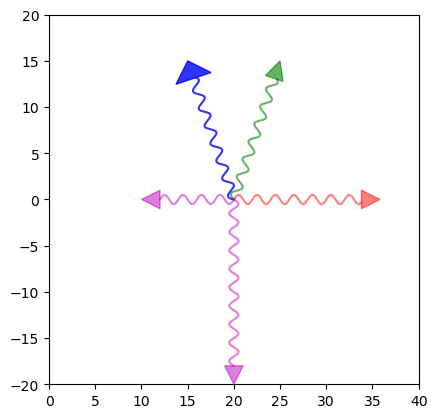

In [6]:
plt.close('all')
fig, ax = plt.subplots(1)

ax.set_xlim((0,40))
ax.set_ylim((-20,20))

x = np.linspace(0,25,151)
y = np.sin(x)
line = WavyCoupling((20,0),(15,15),1,1,2,2,color='b',alpha=0.8,linestyle='-')
ax.add_line(line)
line2 = WavyCoupling((20,0),(25,15),1,1,2,color='g',alpha=0.6,linestyle='-')
ax.add_line(line2)
line3 = WavyCoupling((20,0),(20+15.81,0),1,1,2,color='r',alpha=0.5,linestyle='-')
ax.add_line(line3)
line4 = WavyCoupling((20,0), (10,0), 1,1,2, color='m', alpha=0.5, linestyle='-')
ax.add_line(line4)
line5 = WavyCoupling((20,0), (20,-20), 1,1,2, color='m', alpha=0.5, linestyle='-')
ax.add_line(line5)

ax.set_aspect('equal')

In [3]:
affine = mpl.transforms.Affine2D

class EnergyLevel(mpl.lines.Line2D):
    
    def __str__(self):
        if self._energy is None:
            return "EnergyLevel()"
        else:
            return "EnergyLevel((%g,%g))" % (self._xpos, self._energy)
    
    def __init__(self, energy, xposition, width,
                 right_text='', left_text='', 
                 top_text='', bottom_text='',
                 **kwargs):
        
        self._energy = energy
        self._xpos = xposition
        self._width = width
        # we'll update the position when the line data is set        
        self.text_labels = {'right': mpl.text.Text(xposition + width/2, energy, right_text, ha='left', va='center'),
                            'left': mpl.text.Text(xposition - width/2, energy, left_text, ha='right', va='center'),
                            'top': mpl.text.Text(xposition, energy, top_text, ha='center', va='bottom'),
                            'bottom': mpl.text.Text(xposition, energy, bottom_text, ha='center', va='top')}
        
        x = (xposition - width/2, xposition + width/2)
        y = (energy, energy)
        
        super().__init__(x, y, **kwargs)
        
    def get_center(self):
        
        return self._energy, self._xpos
    
    def get_left(self):
        
        return self._energy, self._xpos - self._width/2
    
    def get_right(self):
        
        return self._energy, self._xpos + self._width/2

    def set_figure(self, figure):
        for side, label in self.text_labels.items():
            label.set_figure(figure)
        super().set_figure(figure)

    def set_axes(self, axes):
        for side, label in self.text_labels.items():
            label.set_axes(axes)
        super().set_axes(axes)

    def set_transform(self, transform):
        # pixel offsets
        pad = 6
        offsets = {'right':(pad, 0),
                   'left':(-pad, 0),
                   'top':(0, pad),
                   'bottom':(0, -pad)}
        for side, label in self.text_labels.items():
            label.set_transform(transform + affine().translate(*offsets[side]))
        super().set_transform(transform)

    def set_data(self, x, y):

        super().set_data(x, y)

    def draw(self, renderer):
        # draw my label at the end of the line with 2 pixel offset
        super().draw(renderer)
        for side, label in self.text_labels.items():
            label.draw(renderer)

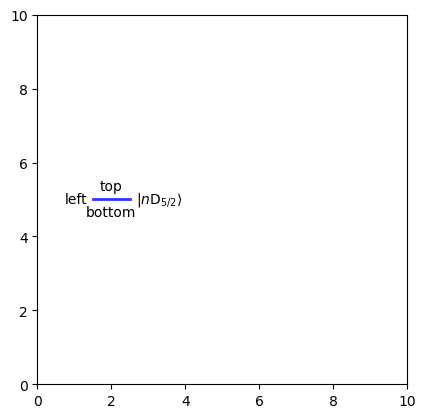

In [4]:
plt.close('all')
fig, ax = plt.subplots(1)

ax.set_xlim((0,10))
ax.set_ylim((0,10))

x = np.linspace(0,25,151)
y = np.sin(x)
lev = EnergyLevel(5, 2, 1,
                  r'$\left|n\mathrm{D}_{5/2}\right\rangle$', 'left', 'top', 'bottom',
                  color='b',alpha=0.8,linestyle='-', lw=2)
ax.add_line(lev)

ax.set_aspect('equal')

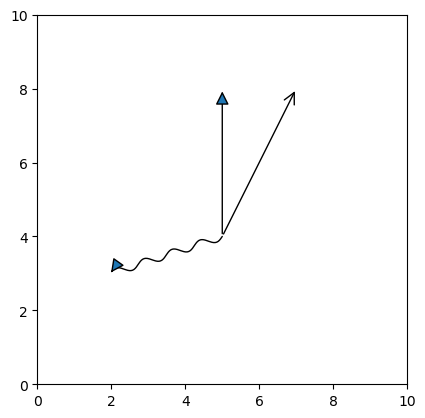

In [11]:
plt.close('all')
fig, ax = plt.subplots(1)

ax.set_xlim((0,10))
ax.set_ylim((0,10))

start = np.array((5,4))
stop = np.array((2,3))
halfperiod = 0.4
waveamp = 0.2
vec = stop - start
dist = np.sqrt(vec.dot(vec))
ang = np.arctan2(*vec[::-1])
rot = np.array([[np.cos(ang),-np.sin(ang)],[np.sin(ang),np.cos(ang)]])
omega = np.pi/halfperiod

amp = waveamp/2
phi = 0
npoints = 151
x0 = np.linspace(0, dist, npoints)
y0 = amp*np.sin(omega*x0 + phi)
points = np.stack((x0,y0))
points_rot = (rot @ points).T + start

arr = mpl.patches.FancyArrowPatch((5,4), (5,8), arrowstyle='-|>', mutation_scale=20)
ax.add_patch(arr)
arr2 = mpl.patches.FancyArrowPatch((5,4), (7,8), arrowstyle='->', mutation_scale=20, mutation_aspect=1)
ax.add_patch(arr2)

arr3 = mpl.patches.FancyArrowPatch(path=mpl.path.Path(points_rot), arrowstyle='-|>', mutation_scale=20)
ax.add_patch(arr3)

ax.set_aspect('equal')

In [33]:
affine = mpl.transforms.Affine2D

class Coupling(mpl.lines.Line2D):
    
    def __str__(self):
        if self._start is None:
            return "Coupling()"
        else:
            return "Coupling((%g,%g)->(%g,%g))" % (*self._start, *self._stop)
    
    def __init__(self, start, stop,
                 arrowsize, arrowratio=1,
                 tail=False,
                 arrow_kw = {},
                 label='', label_offset='center',
                 label_rot = False, label_flip = False,
                 label_kw = {},
                 **kwargs
                 ):
        
        if not np.iterable(start) or not np.iterable(stop):
            raise RuntimeError('x/y data must be a sequence of two elements')
        elif len(start) != 2 or len(stop) != 2:
            raise RuntimeError('x/y data must be a sequence of two elements')
        
        start = np.array(start)
        stop = np.array(stop)
        
        self._start = start
        self._stop = stop
        self._lw = kwargs.get('linewidth',1)
        self._arrowsize = arrowsize
        self._arrowratio = arrowratio
        self._tail = tail
        self.tail = False
        
        x0, y0 = self.init_path()
        super().__init__(x0, y0, **kwargs)
        
        # initialize arrowheads
        # use line kwargs to set arrow defaults
        arrow_kw.update(kwargs)
        self.init_arrowheads(**arrow_kw)
            
        # initialize label text
        self.init_label(label, label_offset, label_rot, label_flip, **label_kw)
            
    def init_path(self):
        
        vec = self._stop - self._start
        dist = np.sqrt(vec.dot(vec))
        self._dist = dist
        self._ang = np.arctan2(*vec[::-1])
        if self._tail:
            x0, y0 = np.stack(((self._arrowsize,0),(dist - self._arrowsize,0))).T
        else:
            x0, y0 = np.stack(((0,0),(dist - self._arrowsize,0))).T
            
        return x0, y0
    
    def init_arrowheads(self, **kwargs):
        
        verts = np.array([[-1,0.5],[-1,-0.5],[0,0]])
        self.head = mpl.patches.Polygon(verts, closed=True, **kwargs)
        if self._tail:
            self.tail = mpl.patches.Polygon(verts, closed=True, **kwargs)
            
    def init_label(self, label, label_offset, label_rot, label_flip, **label_kw):
        
        if label_offset == 'center':
            label_ha = 'center'
            # define softbackground for text
            bbox_defaults = {'boxstyle':'round,pad=0.05','fc':'w','ec':'none','alpha':0.5}
            bbox_dict = label_kw.pop('bbox',{})
            bbox_dict = {**bbox_defaults, **bbox_dict}
            label_kw['bbox'] = bbox_dict
        # flip to match anchor ha settings
        elif label_offset == 'right':
            label_ha = 'left'
        elif label_offset == 'left':
            label_ha = 'right'
        self.text = mpl.text.Text(self._dist/2, 0, label, ha=label_ha, va='center',
                                  transform_rotates_text = label_rot, rotation=label_flip*180,
                                  **label_kw)
        # give space for non-centered text
        self.text_shift = np.array([0,0])
        if not label_rot:
            pad = self.text.get_fontsize()/2 # in points
        else:
            pad = 0
        if label_ha == 'left':
            self.text_shift[0] += pad
        elif label_ha == 'right':
            self.text_shift[0] -= pad
    
    def set_figure(self, figure):
        
        self.head.set_figure(figure)
        if self.tail:
            self.tail.set_figure(figure)
        self.text.set_figure(figure)
        super().set_figure(figure)
        
    def set_axes(self, axes):
        
        self.head.set_axes(axes)
        if self.tail:
            self.tail.set_axes(axes)
        self.text.set_axes(axes)
        super().set_axes(axes)
        
    def set_transform(self, transform):
        
        head_transform = affine().scale(self._arrowsize,
                                        self._arrowsize*self._arrowratio).rotate(self._ang).translate(*self._stop)
        self.head.set_transform(head_transform + transform)
        
        if self.tail:
            tail_transform = affine().scale(self._arrowsize,
                                            self._arrowsize*self._arrowratio).rotate(self._ang+np.pi).translate(*self._start)
            self.tail.set_transform(tail_transform + transform)
        
        text_shim = affine().translate(*self.text_shift) # want to translate in points
        text_transform = affine().rotate(self._ang).translate(*self._start) # translate in 'data' coords
        self.text.set_transform(text_transform + transform + text_shim)

        #lw_shim = affine().scale(
        line_transform = affine().rotate(self._ang).translate(*self._start)
        super().set_transform(line_transform + transform)
        
    def set_data(self, x, y):
        
        super().set_data(x, y)
    
    def draw(self, renderer):
        
        super().draw(renderer)
        self.head.draw(renderer)
        if self.tail:
            self.tail.draw(renderer)
        self.text.draw(renderer)

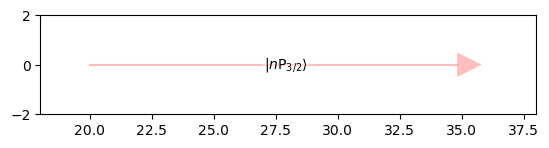

In [37]:
plt.close('all')
fig, ax = plt.subplots(1)

ax.set_xlim((18,38))
ax.set_ylim((-2,2))

ax.add_line(Coupling((20,0),(20+15.81,0),1,1,color='r',alpha=0.25,linestyle='-', tail=False, arrow_kw={'ec':'none'},
                label=r'$|n\mathrm{P}_{3/2}\rangle$', label_offset='center', label_kw={'rotation_mode':'default'}))

ax.set_aspect('equal')

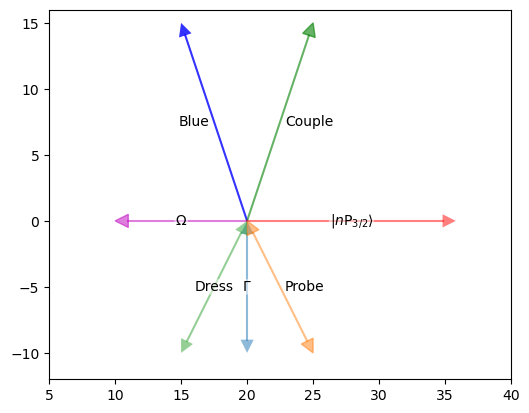

In [36]:
plt.close('all')
fig, ax = plt.subplots(1)

ax.set_xlim((5,40))
ax.set_ylim((-12,16))

ax.add_line(Coupling((20,0),(15,15),1,1,color='b',alpha=0.8,linestyle='-', arrow_kw={'ec':'none'},
                label='Blue', label_offset='left', label_kw={'rotation_mode':'default'}))
ax.add_line(Coupling((20,0),(25,15),1,1,color='g',alpha=0.6,linestyle='-',
            label='Couple', label_offset='right', label_kw={'rotation_mode':'default'}))
ax.add_line(Coupling((20,0),(20+15.81,0),1,1,color='r',alpha=0.5,linestyle='-', arrow_kw={'ec':'none'},
                label=r'$|n\mathrm{P}_{3/2}\rangle$', label_offset='center', label_kw={'rotation_mode':'default'}))
ax.add_line(Coupling((20,0), (10,0), 1,1, color='m', alpha=0.5, linestyle='-',
                    label=r'$\Omega$', label_offset='center', label_kw={'rotation_mode':'default'}))
ax.add_line(Coupling((20,0), (20,-10), 1,1, tail=True, color='C0', alpha=0.5, linestyle='-', arrow_kw={'ec':'none'},
                    label=r'$\Gamma$', label_offset='center', label_kw={'rotation_mode':'default'}))
ax.add_line(Coupling((20,0), (25,-10), 1,1, tail=True, color='C1', alpha=0.5, linestyle='-',
           label='Probe', label_offset='right', label_kw={'rotation_mode':'default'}))
ax.add_line(Coupling((20,0), (15,-10), 1,1, tail=True, color='C2', alpha=0.5, linestyle='-', arrow_kw={'ec':'none'},
            label='Dress', label_offset='center', label_kw={'rotation_mode':'default'}))

ax.set_aspect('equal')

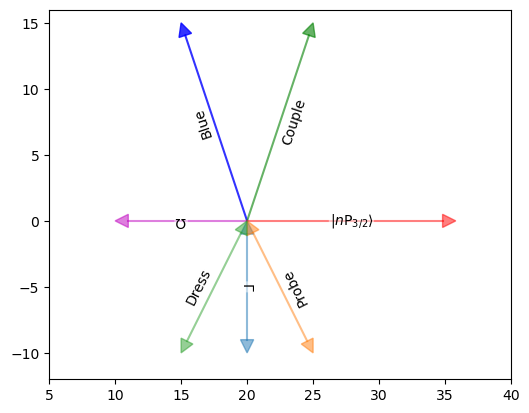

In [7]:
plt.close('all')
fig, ax = plt.subplots(1)

ax.set_xlim((5,40))
ax.set_ylim((-12,16))

ax.add_line(Coupling((20,0),(15,15),1,1,color='b',alpha=0.8,linestyle='-',
                label='Blue', label_offset='left', label_rot=True, label_kw={'rotation_mode':'default'}))
ax.add_line(Coupling((20,0),(25,15),1,1,color='g',alpha=0.6,linestyle='-',
            label='Couple', label_offset='right', label_rot=True, label_kw={'rotation_mode':'default'}))
ax.add_line(Coupling((20,0),(20+15.81,0),1,1,color='r',alpha=0.5,linestyle='-',
                label=r'$|n\mathrm{P}_{3/2}\rangle$', label_offset='center', label_rot=True, label_kw={'rotation_mode':'default'}))
ax.add_line(Coupling((20,0), (10,0), 1,1, color='m', alpha=0.5, linestyle='-',
                    label=r'$\Omega$', label_offset='center', label_rot=True, label_kw={'rotation_mode':'default'}))
ax.add_line(Coupling((20,0), (20,-10), 1,1, tail=True, color='C0', alpha=0.5, linestyle='-',
                    label=r'$\Gamma$', label_offset='center', label_rot=True, label_kw={'rotation_mode':'default'}))
ax.add_line(Coupling((20,0), (25,-10), 1,1, tail=True, color='C1', alpha=0.5, linestyle='-',
           label='Probe', label_offset='right', label_rot=True, label_flip=True, label_kw={'rotation_mode':'default'}))
ax.add_line(Coupling((20,0), (15,-10), 1,1, tail=True, color='C2', alpha=0.5, linestyle='-',
            label='Dress', label_offset='left', label_rot=True, label_flip=True, label_kw={'rotation_mode':'default'}))

ax.set_aspect('equal')

In [38]:
class WavyCoupling(Coupling):
    
    def __str__(self):
        if self._start is None:
            return "WavyCoupling()"
        else:
            return "WavyCoupling((%g,%g)->(%g,%g))" % (*self._start, *self._stop)
    
    def __init__(self, start, stop,
                 waveamp, halfperiod, arrowsize, arrowratio=1,
                 tail=False,
                 arrow_kw = {},
                 label='', label_offset='center',
                 label_rot = False, label_flip = False,
                 label_kw = {},
                 **kwargs
                 ):
        
        self._waveamp = waveamp
        self._halfperiod = halfperiod
        
        if arrowsize*arrowratio < waveamp:
            warnings.warn('Wave amplitude is larger than arrowhead; result will look funny.')
        
        super().__init__(start, stop,
                 arrowsize, arrowratio,
                 tail,
                 arrow_kw,
                 label, label_offset,
                 label_rot, label_flip,
                 label_kw,
                 **kwargs)
        if not np.iterable(start) or not np.iterable(stop):
            raise RuntimeError('x/y data must be a sequence of two elements')
        elif len(start) != 2 or len(stop) != 2:
            raise RuntimeError('x/y data must be a sequence of two elements')
        
    def init_path(self):
        
        vec = self._stop - self._start
        dist = np.sqrt(vec.dot(vec))
        self._dist = dist
        self._ang = np.arctan2(*vec[::-1])
        
        omega = np.pi/self._halfperiod
        
        amp = self._waveamp/2
        phi = omega*self._arrowsize
        npoints = 151
        x0 = np.linspace(0, dist - self._arrowsize, npoints)
        y0 = amp*np.sin(omega*x0 + phi)

        return x0, y0

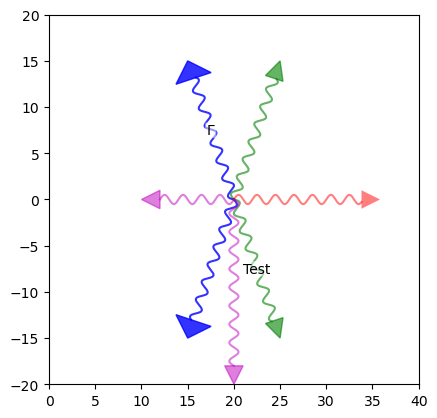

In [44]:
plt.close('all')
fig, ax = plt.subplots(1)

ax.set_xlim((0,40))
ax.set_ylim((-20,20))

x = np.linspace(0,25,151)
y = np.sin(x)
ax.add_line(WavyCoupling((20,0),(15,15),1,1,2,2,color='b',alpha=0.8,linestyle='-', label=r'$\Gamma$'))
ax.add_line(WavyCoupling((20,0),(25,15),1,1,2,color='g',alpha=0.6,linestyle='-'))
ax.add_line(WavyCoupling((20,0),(15,-15),1,1,2,2,color='b',alpha=0.8,linestyle='-'))
ax.add_line(WavyCoupling((20,0),(25,-15),1,1,2,color='g',alpha=0.6,linestyle='-', label='Test'))
ax.add_line(WavyCoupling((20,0),(20+15.81,0),1,1,2,color='r',alpha=0.5,linestyle='-', arrow_kw={'ec':'none'}))
ax.add_line(WavyCoupling((20,0), (10,0), 1,1,2, color='m', alpha=0.5, linestyle='-'))
ax.add_line(WavyCoupling((20,0), (20,-20), 1,1,2, color='m', alpha=0.5, linestyle='-'))


ax.set_aspect('equal')